---
title: "Nielsen's NNDL, ch.2"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

I'm not sure I have something new to add to the vast number of explanations on backpropagation found on the internet. Almost certainly I don't. However, I can only truly grasp a concept if I work it out myself, and that's what this chapter is about. I found [Andrej Karpathy's youtube video](https://www.youtube.com/watch?v=VMj-3S1tku0) on micrograd very useful. He really takes the time to explain the mechanics behind backpropagation. Another useful source was [3b1b youtube videos](https://youtu.be/Ilg3gGewQ5U?si=4q294k85uvQfBucz). It's obvious that he's restating Nielsen's arguments, but with greater pedagogical clarity and superb visualizations.  With regard to Nielsen's approach, I personally hated that he first showed the end form of the equations, and only at the very end of the chapter went about deriving them. At the outset, he says about the first equation "This is a very natural expression". Personally I found nothing natural until I fully understood the derivation. Also, the order of the equations is wrong: what we really need are equations 3 and 4, and equations 1 and 2 are the means to calculate what we need. Nielsen, if you're reading this, know that this criticism comes from a place of love, you did a great service to humanity. I'll stop ranting now, and I'll derive backpropagation myself. If you don't quite get it, it's probably because I'm writing to someone who I assumed to have read Nielsen's book (which you should).

## derivation

### cost

We start with the cost function. For one given input $x$ (one photo of a digit in our dataset), we run our neural network with the usual feed forward algorithm, and get the vector of activations $a$ at the last layer $L$. The cost then will be

$$
C_x = \frac{1}{2} \sum_j \left( y_j - a^L_j\right)^2.
$$

The one half has no special significance here, it will just make life a bit easier in the future, once we take the derivative of the cost. But let's not get distracted.

We sum over $j$, the index counting the number of neurons in the output layer, which in our case is 10. $y_j$ represents the one-hot label of the digit in $x$. For instance, for the digit $3$ we might get something like that:

$$
y =
\begin{bmatrix}
0\\0\\0\\1\\0\\0\\0\\0\\0\\0
\end{bmatrix},
\quad
a^L =
\begin{bmatrix}
0.1\\0.7\\0.0\\0.5\\0.4\\0.6\\0.1\\0.0\\0.1\\0.6
\end{bmatrix},
\quad
(y-a^L)^2 =
\begin{bmatrix}
0.01\\0.49\\0.0\\0.25\\0.16\\0.36\\0.01\\0.0\\0.01\\0.36
\end{bmatrix}.
$$

Then $C_x$ is just half of the sum of this last vector. So far so good. But what about all the other thousands of input images? We do the same for them, and get the total cost for our entire dataset:

$$
C = \frac{1}{n}\sum_x C_x
$$

### rule for updating the parameters

Our goal is to update each and every weight and bias in our neural network, so to decrease as much as we can this cost. The lower the cost, the more accurate will be our number classification.

This cost lives in a multi-dimensional space. By the gradient descent method, we take a tiny step in the parameter space in the direction opposite to the gradient of the cost. If $p$ is to represent our parameter vector, than we would write

$$
p_\text{new} = p_\text{old} - \eta \nabla C,
$$

where $\eta$ is the learning rate. 

Each element of $p$ is a weight or bias in the network. Now is the right time to be precise and refer specifically to each parameter, and first we need a good mental model for the parameters.

In [21]:
#| code-summary: "import libraries"
import os
import io
import gzip
import numpy as np
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.patches as patches

[(-0.5, 4.0), (-5.0, 4.0), [], []]

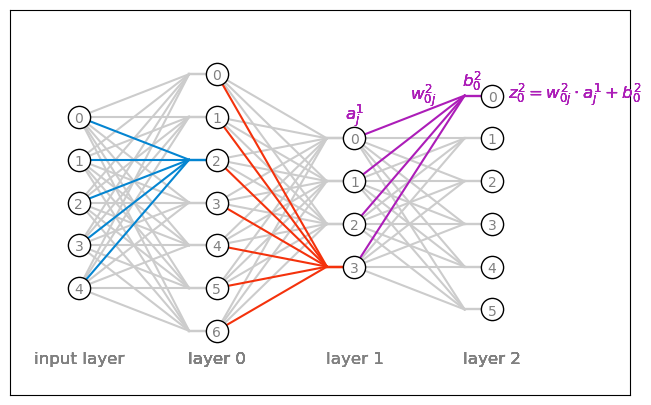

In [89]:
fig, ax = plt.subplots(figsize=(8, 5))

layer_left = 5
layer_center = 7
layer_right = 4
layer_right2 = 6

layers = [layer_left, layer_center, layer_right, layer_right2]




weights = []
for l, layer in enumerate(layers[:-1]):
    weights.append(np.ones((layers[l+1], layer)))

for l,w in enumerate(weights):
    x_left = l
    x_right = l+1-0.2
    x_b = l+1
    for index, value in np.ndenumerate(w):
        y_right = index[0] - layers[l+1]/2
        y_left = index[1] - layers[l]/2
        zorder = 100
        if (l==0 and index[0]==4):
            color = "xkcd:cerulean"
        elif (l==1 and index[0]==0):
            color = "xkcd:vermillion"
        elif (l==2 and index[0]==layers[l+1]-1):
            color = "xkcd:barney"
            ax.text(x_b-0.5, np.max(layers)/2 - 1 - 0.2, fr"$w_{{0j}}^{l}$", ha="center", va="top", fontsize=12, color=color, zorder=1000)
            ax.text(x_b-0.15, np.max(layers)/2 - 1 +0.1, fr"$b_{{0}}^{l}$", ha="center", va="top", fontsize=12, color=color, zorder=1000)
            ax.text(x_b+0.6, np.max(layers)/2 - 1.5, fr"$z_{{0}}^{l} = w_{{0j}}^{l}\cdot a_{{j}}^{l-1} + b_{{0}}^{l}$", ha="center", va="center", fontsize=12, color=color, zorder=1000)
            ax.text(x_b-1, (layers[2])/2-0.5, fr"$a_{{j}}^{l-1}$", ha="center", va="center", fontsize=12, color=color, zorder=1000)
        else: color = [0.8]*3; zorder = 0
        ax.plot([x_left, x_right], [y_left, y_right], color=color, zorder=zorder)
        ax.plot([x_b, x_right], [y_right, y_right], color=color, zorder=zorder)

ms = 16
for l, layer in enumerate(layers):
    for i in range(layer):
        ax.plot([l], [i - layer/2], ls='None', marker='o', mfc="white", mec="black", markersize=ms,
                color="gray", lw=2, alpha=1.0, zorder=1000)
        ax.text(l, i - layer/2-0.05, f"{layer-i-1}", ha="center", va="center", fontsize=10, color="gray", zorder=1000)
        if l ==0:
            ax.text(l, -np.max(layers)/2-0.5, f"input layer", ha="center", va="top", fontsize=12, color="gray", zorder=1000)
        if l >=1:
            ax.text(l, -np.max(layers)/2-0.5, f"layer {l-1}", ha="center", va="top", fontsize=12, color="gray", zorder=1000)
        
# for i in range(layer_left):
#     for j in range(layer_right):
#         if i == 2:
#             color = "xkcd:cerulean"
#             alpha = 1.0
#         else:
#             alpha = 0.5
#             color = "gray"
#         ax.plot([0, 1], [(layer_left - i)/layer_left, (layer_right - j + 1.5)/layer_left], 
#                 color=color, lw=2, alpha=alpha)
        

# for i in range(layer_left):
#     if i == 2:
#         color = "xkcd:vermillion"
#         alpha = 1.0
#     else:
#         color = "white"
#         alpha = 1.0
#     ax.plot([0], [(layer_left - i)/layer_left], ls='None', marker='o', mfc=color, 
#             mec="gray", markersize=ms, alpha=alpha)
#     ax.text(-0.1, (layer_left - i)/layer_left, fr"$\delta_{i}^\ell$", 
#                 va='center', ha='right', fontsize=12, color="gray")
    
# for i in range(layer_right):
#     color = "xkcd:goldenrod"
#     ax.plot([1], [(layer_right - i + 1.5)/layer_left], ls='None', marker='o', mfc=color, 
#             mec="gray", markersize=ms)
#     ax.text(1.1, (layer_right - i + 1.5)/layer_left, fr"$\delta_{i}^{{\ell+1}}$", 
#                 va='center', ha='left', fontsize=12, color="gray")

# ax.text(0.5, 0.9, r"$w_{ij}$", fontsize=12, color="gray")
# ax.text(0, 0, r"layer $\ell$", va="top", ha="center", fontsize=14)
# ax.text(1, 0, r"layer $\ell+1$", va="top", ha="center", fontsize=14)

ax.set(xlim=(-0.5, 4), ylim=(-5, 4), xticks=[], yticks=[])
# ax.set_aspect('equal')
# ax.axis('off');

In [33]:
stam = rng.normal(size=(3, 4))
for index, value in np.ndenumerate(stam):
    print(index, value)

(0, 0) -0.43643524714322124
(0, 1) -1.169801907772864
(0, 2) 1.739367877130134
(0, 3) -0.4959107284421519
(1, 0) 0.3289696294602021
(1, 1) -0.258572545473924
(1, 2) 1.5834728788021222
(1, 3) 1.3203609870818391
(2, 0) 0.6333526228249152
(2, 1) -2.2035098806466507
(2, 2) 0.05202897425988651
(2, 3) 0.6836861907765345









Translating the equation above to a generic weight and bias term gives:

\begin{align*}
w_\text{new} &= w_\text{old} - \eta \frac{\partial C}{\partial w_\text{old}} \\ \\
b_\text{new} &= b_\text{old} - \eta \frac{\partial C}{\partial b_\text{old}}.
\end{align*}

In order to talk about specific weights and biases, we need to introduce indices, but for now that would be a distraction.

Now that we have the rule to update our parameters, "all we have to do" is to figure out the partial derivatives in the equations above.

### the structure of the argument

The backpropagation algorithm is at its essence an induction.

1. We can find out the partial derivatives for the very last layer, the output layer. This is the Base Case.
1. We can show that given the partial derivatives in any given layer $\ell$, we can figure out what the partial derivatives are in the layer that precedes it, $\ell-1$. This is the Inductive Step.
1. That's it. Starting from the last layer, we can work our way out to the first layer. That explains the name of the algorithm, we're backpropagating the information, from last to first.

## the "error"

In the previous chapter we defined the weighted input $z$ as

$$
z = w\cdot a + b.
$$

Now is the time to be more precise and introduce indices:

$$
z^\ell_j = \sum_k w^\ell_{jk} a^{\ell-1}_k + b^\ell_j.
$$

Let's understand the indices. The superscript $\ell$ indicates the layer we're talking about. The activation $a$ receives the superscript $\ell-1$ because it belongs to the previous layer. The weight $w$ has two subscripts, $j$ and $k$, because it connects the $k$th neuron in layer $\ell-1$ to the $j$th neuron in layer $\ell$. The bias $b$ has only one subscript, $j$, because it belongs to the $j$th neuron in layer $\ell$.

For a given weight or bias, let's use the chain rule to begin unfolding the partial derivatives we need to find out.

\begin{align*}
\frac{\partial C}{\partial w^\ell_{jk}} &= \left( \frac{\partial C}{\partial z^\ell_j} \right) \frac{\partial z^\ell_j}{\partial w^\ell_{jk}} = \left( \frac{\partial C}{\partial z^\ell_j} \right) a^{\ell-1}_k  \\ \\
\frac{\partial C}{\partial b^\ell_j} &= \left(\frac{\partial C}{\partial z^\ell_j}\right) \frac{\partial z^\ell_j}{\partial b^\ell_j} = \left( \frac{\partial C}{\partial z^\ell_j} \right).
\end{align*}

This is great, now both terms look almost the same! We found that we need to calculate the quantity in the parentheses, which we will call the error:

$$
\delta^\ell_j =\frac{\partial C}{\partial z^\ell_j}
$$

The equation above asks: how sensitive is the total cost $C$ to tiny variations in a specific weighted input $z$ at the $j$th neuron in layer $\ell$.

Let's compute this error for the last layer $L$, and lay out the Base Case of our induction.

## base case: the output layer

The last layer has index $L$, and the error for the $j$th neuron in this layer is
$$
\delta^L_j = \frac{\partial C}{\partial z^L_j}.
$$

Let's use the chain rule to unfold this derivative:

$$
\delta^L_j = \frac{\partial C}{\partial a^L_j} \frac{\partial a^L_j}{\partial z^L_j}.
$$

Remember that the activation $a$ is simply

$$
a = \sigma(z),
$$

so we have that $\partial a/\partial z=\sigma'(z)$. Rewriting the error gives

$$
\delta^L_j = \frac{\partial C}{\partial a^L_j} \cdot \sigma'(z^L_j).
$$

We're in luck, because each of the two terms in the right hand side of the equation above is easy to calculate. The first term is

\begin{align*}
\frac{\partial C}{\partial a^L_j} &= \frac{\partial}{\partial a^L_j} \left[ \frac{1}{n}\sum_x \frac{1}{2} \sum_j \left( y_j - a^L_j\right)^2 \right] \\
&=
\frac{1}{n}\sum_x \sum_j \left( y_j - a^L_j\right).
\end{align*}

Let's translate that into words: the first term is simply the difference $\left( y_j - a^L_j\right)$, summed over all neurons $j$ in the output layer, and averaged over all input images $x$. That's super easy to compute! Let's see the second term:

$$
\sigma'(z^L_j)
$$

The derivative of $\sigma$ depends on the specific function we choose. Let's calculate what the answer would be for two commonly used activation functions, the sigmoid and relu. For the sigmoid:

\begin{align*}
\sigma(z) &= \frac{1}{1+\exp(-z)} \\
\sigma'(z) &= \sigma(z)\left(1-\sigma(z)\right).
\end{align*}

For the relu:

\begin{align*}
\sigma(z) &= \max(0,z) \\
\sigma'(z) &= \begin{cases}
0 & z < 0 \\
1 & z > 0
\end{cases}
\end{align*}

In either case, the derivative is easy to compute, and we have the Base Case of our induction.

## the inductive step: the hidden layers

The arguments here are also based on a bunch of partial derivatives and the chain rule. We start from the error in a generic layer $\ell$:

$$
\delta^\ell_j = \frac{\partial C}{\partial z^\ell_j}.
$$

This error is influenced by the errors in the next layer $\ell+1$, so we now use the chain rule to express this relationship:

$$
\delta^\ell_j = \sum_k \frac{\partial C}{\partial z^{\ell+1}_k} \frac{\partial z^{\ell+1}_k}{\partial z^\ell_j} = \underbrace{\sum_k \delta^{\ell+1}_k \frac{\partial z^{\ell+1}_k}{\partial z^\ell_j}}_{\text{summation over layer $\ell+1$}}.
$$

Let's interpret this equation, using the image below to help us. We are already used to the idea that the activation of a neuron in layer $\ell$ propagates to the next layer $\ell+1$, from left to right. This is what the blue lines in the image below represent.

The conceptual jump now is to use these same lines to understand how the error in layer $\ell+1$ **propagates back** to layer $\ell$, from right to left. The equation above says that the error in layer $\ell$ is the sum of the errors in layer $\ell+1$, weighted by something that should be related to the strength of the connection between the neurons in layer $\ell$ and layer $\ell+1$.

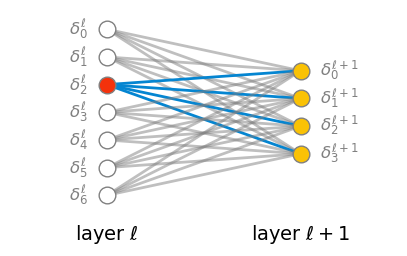

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))

layer_left = 7
layer_right = 4
ms = 12
for i in range(layer_left):
    for j in range(layer_right):
        if i == 2:
            color = "xkcd:cerulean"
            alpha = 1.0
        else:
            alpha = 0.5
            color = "gray"
        ax.plot([0, 1], [(layer_left - i)/layer_left, (layer_right - j + 1.5)/layer_left], 
                color=color, lw=2, alpha=alpha)
        

for i in range(layer_left):
    if i == 2:
        color = "xkcd:vermillion"
        alpha = 1.0
    else:
        color = "white"
        alpha = 1.0
    ax.plot([0], [(layer_left - i)/layer_left], ls='None', marker='o', mfc=color, 
            mec="gray", markersize=ms, alpha=alpha)
    ax.text(-0.1, (layer_left - i)/layer_left, fr"$\delta_{i}^\ell$", 
                va='center', ha='right', fontsize=12, color="gray")
    
for i in range(layer_right):
    color = "xkcd:goldenrod"
    ax.plot([1], [(layer_right - i + 1.5)/layer_left], ls='None', marker='o', mfc=color, 
            mec="gray", markersize=ms)
    ax.text(1.1, (layer_right - i + 1.5)/layer_left, fr"$\delta_{i}^{{\ell+1}}$", 
                va='center', ha='left', fontsize=12, color="gray")

# ax.text(0.5, 0.9, r"$w_{ij}$", fontsize=12, color="gray")
ax.text(0, 0, r"layer $\ell$", va="top", ha="center", fontsize=14)
ax.text(1, 0, r"layer $\ell+1$", va="top", ha="center", fontsize=14)

ax.set(xlim=(-0.5, 1.5), ylim=(0, 1.1), xticks=[], yticks=[])
ax.set_aspect('equal')
ax.axis('off');

We need now to evaluate the term

$$
\frac{\partial z^{\ell+1}_k}{\partial z^\ell_j}.
$$

Remember that the weighted input $z$, at the $k$-th neuron in layer $\ell+1$, is defined as

$$
z^{\ell+1}_k = \sum_j w_{kj}^{\ell+1} a^\ell_j + b_k^{\ell+1}.
$$

Remember also that the activation $a$ is a function of the weighted input $z$, $a = \sigma(z)$. Putting all this together gives

\begin{align*}
\frac{\partial z^{\ell+1}_k}{\partial z^\ell_j} &= \frac{\partial z^{\ell+1}_k}{\partial a^\ell_j} \cdot \frac{\partial a^\ell_j}{\partial z^\ell_j} \\
&= w_{kj} \sigma'(z^\ell_j).
\end{align*}

Finally, we can rewrite the error in layer $\ell$ as

$$
\delta^\ell_j = \sum_k \delta^{\ell+1}_k w_{kj} \sigma'(z^\ell_j).
$$

Once more, all the terms in the right hand side of the equation above are easy to compute, and we have the Inductive Step of our argument.

## summary

We've learned the following. For each weight and bias $j$ in any layer $\ell$, we can compute the error $\delta^\ell_j$ and update the parameters according to:

\begin{align*}
w_{jk}^\ell &\leftarrow w_{jk}^\ell - \eta a^{\ell-1}_k \delta_j^\ell \\ \\
b_j^\ell &\leftarrow b_j^\ell - \eta \delta_j^\ell.
\end{align*}

The backpropagation algorithm tells us to start from the last layer, compute the error there, and then work our way back to the first layer, computing the error in each layer and updating the parameters accordingly. The errors in the last layer are:

$$
\delta^L_j = \left[ \frac{1}{n}\sum_x \sum_k(y_k - a_k^L) \right] \cdot \sigma'(z^L_j),
$$

and the errors in the hidden layers are:

$$
\delta^\ell_j = \sum_k \delta^{\ell+1}_k w_{kj} \sigma'(z^\ell_j).
$$

## batches

Instead of computing the cost and the errors for the entire dataset, we can do it for a small random sample of the data, called a batch. We just need to reinterpret the summation over $x$ in the equations above as a summation over the batch. This is what stochastic gradient descent is all about. It allows us to update the parameters more frequently, and it also adds some noise to the process, which makes our descent in the cost landscape less smooth, but can also help to escape local minima.

We start by shuffling our dataset, and then splitting it into batches. Then, for each batch, we perform:

1. the feedforward algorithm to compute the activations and weighted inputs for each layer, and finally the cost for the batch;
1. the backpropagation algorithm to compute the errors for each layer.
1. the update of the parameters according to the equations above.

Once we've done this for all batches, we have completed one **epoch** of training. We can repeat this process for as many epochs as we want, until the cost is sufficiently low. We usually test the performance of our network on a separate test set, and track it as a function of the number of epochs.

## vectorizing Nielsen's backpropagation code

Nielsen mentions in the book that the code, as it is written, is not optimized. He proposes the following problem to solve:

> Fully matrix-based approach to backpropagation over a mini-batch Our implementation of stochastic gradient descent loops over training examples in a mini-batch. It's possible to modify the backpropagation algorithm so that it computes the gradients for all training examples in a mini-batch simultaneously. The idea is that instead of beginning with a single input vector, x, we can begin with a matrix X=[x1x2…xm] whose columns are the vectors in the mini-batch. We forward-propagate by multiplying by the weight matrices, adding a suitable matrix for the bias terms, and applying the sigmoid function everywhere. We backpropagate along similar lines. Explicitly write out pseudocode for this approach to the backpropagation algorithm. Modify network.py so that it uses this fully matrix-based approach. The advantage of this approach is that it takes full advantage of modern libraries for linear algebra. As a result it can be quite a bit faster than looping over the mini-batch. (On my laptop, for example, the speedup is about a factor of two when run on MNIST classification problems like those we considered in the last chapter.) In practice, all serious libraries for backpropagation use this fully matrix-based approach or some variant.

I'll write below the actual code, not the pseudocode. I'll then compare the performance of the vectorized code with the original code, and see if I can get a speedup of about a factor of two, as Nielsen claims.

Note: I've made a few updates to the original code in the book. In general, I wrote it to be more "modern" (I'm writing this in 2026). Also, I made sure I didn't copy and paste anything, I'm typing it myself so I take ownership of this code. Here are the major modifications in this chapter:

1. I've added ReLU as the default activation function, but you can choose sigmoid if you want.
1. I added a progress bar to the training loop using `tqdm` to visualize the training progress.
1. You can quit training early by pressing `Ctrl+C`, the model will keep the weights without raising an error.
1. I've vectorized the backpropagation algorithm to handle batches efficiently, which should speed up training significantly.

In [ ]:
class NN:
    def __init__(self, layer_sizes, rand_seed=0):
        self.number_of_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        # randomly initialize weights and biases
        # input layer has no weights nor biases, so we skip it.
        rng = np.random.default_rng(seed=rand_seed)
        # each neuron get 1 bias, so bias vector has the size of the layer
        self.biases = [rng.normal(loc=0, scale=1, size=N_b)
                       for N_b in layer_sizes[1:]]
        # each neuron in layer Right is connected to all neurons in layer Left,
        # so weight matrix has the shape (size_left, size_right)
        self.weights = [rng.normal(loc=0, scale=1, size=(size_left,size_right))
                        for size_left, size_right in
                          zip(layer_sizes[:-1],layer_sizes[1:])
                        ]
    
    def feedforward(self, a):
        """given input `a` from the first layer,
           computes sequencially the activations of each layer
           finally returns the activations of last (output) layer
        """
        for b, w in zip(self.biases, self.weights):
            z = np.dot(a, w) + b
            a = activation_func(z)
        return a
    
    def stochastic_gradient_descent(self, training_data, epochs, batch_size, eta, test_data=None):
        n = len(training_data)
        for epoch_j in range(epochs):
            # shuffle training data at the beginning of each epoch
            rng.shuffle(training_data)
            # split training data into batches
            batches = [
                training_data[k:k+batch_size]
                for k in range(0, n, batch_size)
            ]
            # now loop over batches, update weights
            for batch in batches:
                self.update_params_batch(batch, eta)
            if test_data:
                print("Epoch {epoch_j:02d}/{epochs}: {self.evaluate(test_data)} / {len(test_data)}")
            else:
                print(f"Epoch {epoch_j:02d} complete")
    
    def update_params_batch(self, batch, eta):
        # 1. make input matrix, use row-major order, so each row is a training example, and each column is a feature.
        input = np.array([data[0] for data in batch])
        # 2. make label matrix, use row-major order, so each row is a training example, and each column is a label.
        target = np.array([data[1] for data in batch])
        # 3. compute the gradients for the whole batch using back propagation
        nabla_b, nabla_w = self.back_propagation(input, target)
        # update biases and weights
        m = len(batch)
        self.biases = [
            b - (eta/m) * nb
            for b, nb in zip(self.biases, nabla_b)
        ]
        self.weights = [
            w - (eta/m) * nw
            for w, nw in zip(self.weights, nabla_w)
        ]
    
    def back_propagation(self, input, target):
        # 1. forward pass
        # 1a. create variables to store the activations and z vectors for each layer, starting with the input layer
        activation = input
        activation_list = [input]  # initialize with input layer activations
        z_list = []
        # 1b. loop over layers in forward direction,
        # compute and store the activations and z vectors layer by layer
        # for the whole batch at once.
        for b, w in zip(self.biases, self.weights):
            z = np.dot(activation, w) + b
            activation = activation_func(z)
            z_list.append(z)
            activation_list.append(activation)
        #####
        # now we have all the information we need to compute the gradients in the backward pass.
        #####
        # 2. backward pass
        # 2a. create empty lists to store the gradients for biases and weights, layer by layer
        nabla_b = [np.zeros_like(b) for b in self.biases]
        nabla_w = [np.zeros_like(w) for w in self.weights]
        # 2b. first compute the error "delta" for the output layer
        # this is what we called the "base case"
        delta = self.cost_derivative(activation_list[-1], target) * activation_func_derivative(z_list[-1])
        # 2c. compute and store the gradients for the output layer
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(activation_list[-2].T, delta)
        # 2c. loop over layers in reverse order,
        # compute the gradients for each layer. This is the "inductive step".
        # the loop starts at the second to last layer, and goes backwards to the first hidden layer.
        for l in range(2, self.number_of_layers):
            z = z_list[-l]
            # the transpose is needed because we want to compute the dot product
            # of the error from the next layer with the weights,
            # and the weights are stored in a way that the input layer is the first dimension,
            # and the output layer is the second dimension.
            delta = np.dot(delta, self.weights[-l+1].T) * activation_func_derivative(z)
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(activation_list[-l-1].T, delta)
        return nabla_b, nabla_w